# Project 4 - Monreader

**Introduction:**

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

**Data Description:**

Data consiste of page flipping videos from smart phones. These are labelled as flipping and not flipping. These were posteriorly clipped as short videos and again labelled as flipping or not flipping. The extracted frames were then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Goal(s):**

Predict if the page is being flipped using a single image.

**Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

**Bonus(es):**

Predict if a given sequence of images contains an action of flipping.

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import sys

sys.path.append('../')


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader
import torch.optim as optim
import gc

# del variables
# gc.collect()
torch.cuda.empty_cache()

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

## Get images

In [3]:
from utils import get_data_csv, imshow, Net, train, visualize_model, get_classification_report, save_model

DATA_PATH = 'images'
DATASET_CSV_PATH = 'datasets'

BATCH_SIZE = 1
NUM_WORKERS = 2

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
# python image library of range [0, 1], transform them to tensors of normalized range[-1, 1]
torch.manual_seed(42)
data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(256),
        transforms.RandomRotation(degrees=(0, 360)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# print(image_datasets)
print('split\t', dataset_sizes, '\nclasses\t', class_names, '\ndevice\t', device)

split	 {'train': 2392, 'val': 597} 
classes	 ['flip', 'notflip'] 
device	 cuda:0


Image batch shape: torch.Size([4, 1, 1920, 1080])
Labels batch shape: torch.Size([4])


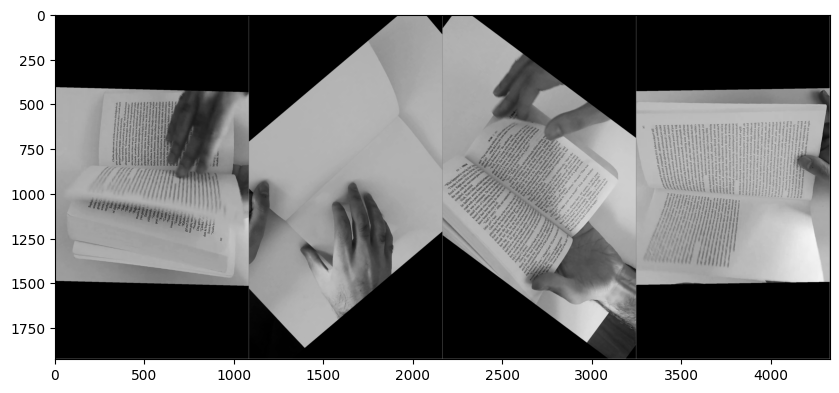

flip notflip flip flip


In [5]:
# Display image and label.
train_images, train_labels = next(iter(dataloaders['train']))
print(f"Image batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# We are going to visualize the same amount of images as our batch size
imshow(torchvision.utils.make_grid(train_images), class_names, train_labels)
print(' '.join('%s' % class_names[train_labels[j]] for j in range(BATCH_SIZE)))

In [6]:
net = Net(device)
net.to(device)
# print(net.device)
# print(next(net.parameters()).device)
print(net)

params = list(net.parameters())
print('params:', len(params), '\tparams size:', params[0].size())  # conv1's .weight

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2049664, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
params: 10 	params size: torch.Size([6, 1, 5, 5])


In [7]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [9]:
LR = 0.001
EPOCH = 5

criterion = nn.CrossEntropyLoss() # Classification problem
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=LR)
epoch, loss = train(bs=BATCH_SIZE, epochs=EPOCH, train_loader=dataloaders['train'], opt=optimizer, model=net, criterion=criterion, device=device)
save_model(model=net, epoch=epoch, loss=loss, path='model_p4.pt', optimizer=optimizer)

EPOCH  0
BATCH IDX  0


OutOfMemoryError: CUDA out of memory. Tried to allocate 470.00 MiB (GPU 0; 5.81 GiB total capacity; 3.99 GiB already allocated; 242.00 MiB free; 4.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
print('TRAIN')
get_classification_report(net, dataloaders['train'], device)

print('\nVAL')
get_classification_report(net, dataloaders['val'], device)

TRAIN
              precision    recall  f1-score   support

           0       1.00      0.35      0.52        34
           1       0.58      1.00      0.73        30

    accuracy                           0.66        64
   macro avg       0.79      0.68      0.63        64
weighted avg       0.80      0.66      0.62        64


VAL
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        26
           1       0.75      0.95      0.84        38

    accuracy                           0.78        64
   macro avg       0.81      0.74      0.75        64
weighted avg       0.80      0.78      0.77        64



In [ ]:
visualize_model(net, dataloaders['val'], class_names, device)

In [9]:
model = Net(device)
model.to(device)

params = list(model.parameters())
checkpoint = torch.load('model_p4.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=107360, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
test_data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])

test_dataset = datasets.ImageFolder(os.path.join(DATA_PATH, 'final preprocessed'), test_data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

test_dataset_size = len(test_dataset)
test_class_names = test_dataset.classes

# print(image_datasets)
print('size:\t', test_dataset_size, '\nclasses\t', test_class_names, '\n', device)

size:	 2509 
classes	 ['flip', 'no flip'] 
 cuda:0


Feature batch shape: torch.Size([64, 1, 256, 465])
Labels batch shape: torch.Size([64])


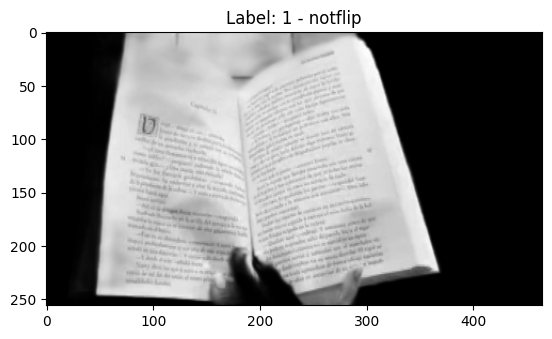

In [28]:
# Display image and label.
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label} - {class_names[label]}")
plt.show()

In [29]:
print('\nTEST')
get_classification_report(net, test_dataloader, device)


TEST


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x110288 and 107360x120)